In [3]:
!pip install "numpy<2.0" --force-reinstall
!pip install pandas numpy matplotlib


  Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
roboflow 1.1.33 requires chardet==4.0.0, but you have chardet 3.0.4 which is incompatible.
roboflow 1.1.33 requires idna==3.7, but you have idna 2.10 which is incompatible.
blis 1.0.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.2 requires numpy<2.1.0,>=2.0.0; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
ultralyticsplus 0.0.28 requires ultralytics<8.0.44,>=8.0.43, but you have ultralytics 8.2.87 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip i


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Cell 1: imports and seed
import csv
import random
import itertools
import copy
import math
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [5]:
# Cell 2: Generate tasks.csv, resources.csv, weather.csv (synthetic / realistic-like)

# --- tasks.csv (Flow-Bench style) ---
tasks = [
    (1, "data_ingest", 180, 500, ""),            # id, name, runtime_sec, data_mb, deps
    (2, "data_cleaning", 150, 450, "1"),
    (3, "feature_extraction", 200, 300, "2"),
    (4, "model_training", 600, 200, "3"),
    (5, "model_validation", 240, 150, "4"),
    (6, "report_generation", 120, 100, "5"),
    (7, "dashboard_update", 90, 50, "5;6"),
    (8, "alerting", 60, 50, "7"),
    (9, "archiving", 150, 400, "8"),
    (10,"notification", 45, 20, "9")
]

with open("tasks.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["task_id", "task_name", "runtime_sec", "data_size_mb", "dependencies"])
    for t in tasks:
        writer.writerow(t)

# --- resources.csv (SpotLake-inspired) ---
resources = [
    (1, "AWS_m5.large", "AWS", 0.12, 1.0, 0.99, "us-east-1"),
    (2, "GCP_n1-standard-2", "GCP", 0.10, 0.9, 0.98, "us-central1"),
    (3, "Azure_B2s", "Azure", 0.08, 0.8, 0.97, "eastus"),
    (4, "AWS_c5.xlarge", "AWS", 0.15, 1.2, 0.995, "us-west-2"),
    (5, "GCP_e2-highcpu-4", "GCP", 0.11, 1.1, 0.985, "europe-west1"),
    (6, "Azure_D4_v3", "Azure", 0.14, 1.3, 0.99, "westeurope")
]

with open("resources.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["resource_id", "resource_name", "provider", "cost_per_sec",
                     "speed_multiplier", "reliability", "region"])
    for r in resources:
        writer.writerow(r)

# --- weather.csv (synthetic) ---
# We model per-region weather states that affect network and resource performance.
weather_states = [
    ("us-east-1", "clear"),
    ("us-central1", "cloudy"),
    ("eastus", "rain"),
    ("us-west-2", "clear"),
    ("europe-west1", "storm"),
    ("westeurope", "cloudy")
]

with open("weather.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["region", "weather"])
    for w in weather_states:
        writer.writerow(w)

print("Generated tasks.csv, resources.csv, weather.csv")


Generated tasks.csv, resources.csv, weather.csv


In [6]:
# Cell 3: Load CSVs into memory structures
tasks_df = pd.read_csv("tasks.csv")
resources_df = pd.read_csv("resources.csv")
weather_df = pd.read_csv("weather.csv")

# Build tasks dict
tasks = {}
for _, row in tasks_df.iterrows():
    tid = int(row["task_id"])
    deps = []
    if isinstance(row["dependencies"], str) and row["dependencies"].strip():
        deps = [int(x) for x in row["dependencies"].split(";") if x.strip()]
    tasks[tid] = {
        "id": tid,
        "name": row["task_name"],
        "runtime": float(row["runtime_sec"]),
        "data_size": float(row["data_size_mb"]),
        "deps": deps
    }

# Build resources list
resources = []
for _, row in resources_df.iterrows():
    resources.append({
        "id": int(row["resource_id"]),
        "name": row["resource_name"],
        "provider": row["provider"],
        "cost_per_sec": float(row["cost_per_sec"]),
        "speed": float(row["speed_multiplier"]),
        "reliability": float(row["reliability"]),
        "region": row["region"]
    })

# Weather map region -> weather state
weather_map = {row["region"]: row["weather"] for _, row in weather_df.iterrows()}

# Topological sort
def topo_sort(tasks):
    indeg = {tid: 0 for tid in tasks}
    children = defaultdict(list)
    for tid, t in tasks.items():
        for p in t["deps"]:
            children[p].append(tid)
            indeg[tid] += 1
    queue = [tid for tid, d in indeg.items() if d == 0]
    order = []
    while queue:
        n = queue.pop(0)
        order.append(n)
        for c in children[n]:
            indeg[c] -= 1
            if indeg[c] == 0:
                queue.append(c)
    if len(order) != len(tasks):
        raise ValueError("Cycle detected or invalid DAG")
    return order

topo_order = topo_sort(tasks)

print("Loaded", len(tasks), "tasks,", len(resources), "resources")
print("Topological order:", topo_order)
print("Weather map:", weather_map)


Loaded 10 tasks, 6 resources
Topological order: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Weather map: {'us-east-1': 'clear', 'us-central1': 'cloudy', 'eastus': 'rain', 'us-west-2': 'clear', 'europe-west1': 'storm', 'westeurope': 'cloudy'}


In [7]:
# Cell 4: Transfer matrix + weather impact model

# Providers set
providers = sorted(set(r["provider"] for r in resources))

# Base transfer speeds (MB/sec) and costs ($/MB)
transfer_speed = {}
transfer_cost = {}
# intra-provider faster and cheaper
for p in providers:
    transfer_speed[(p,p)] = 200.0  # intra-cloud
    transfer_cost[(p,p)] = 0.0001

# cross-provider slower & costlier
for a, b in itertools.permutations(providers, 2):
    transfer_speed[(a,b)] = 50.0
    transfer_cost[(a,b)] = 0.001

# Weather effects: factor to multiply speeds and costs
# Example: 'storm' reduces speed to 50% and increases cost by 50%
weather_effects = {
    "clear": {"speed_factor": 1.0, "cost_factor": 1.0, "resource_speed_factor": 1.0},
    "cloudy": {"speed_factor": 0.95, "cost_factor": 1.02, "resource_speed_factor": 0.98},
    "rain": {"speed_factor": 0.85, "cost_factor": 1.05, "resource_speed_factor": 0.95},
    "storm": {"speed_factor": 0.6, "cost_factor": 1.2, "resource_speed_factor": 0.9}
}

# function to get transfer speed & cost considering weather at source + dest regions
def get_transfer_params(src_provider, src_region, dst_provider, dst_region):
    # base
    speed = transfer_speed[(src_provider, dst_provider)]
    cost_per_mb = transfer_cost[(src_provider, dst_provider)]

    # region weather modifiers — use min of both regions' speed_factors (worst-case)
    src_weather = weather_map.get(src_region, "clear")
    dst_weather = weather_map.get(dst_region, "clear")
    src_eff = weather_effects.get(src_weather, weather_effects["clear"])
    dst_eff = weather_effects.get(dst_weather, weather_effects["clear"])
    speed_factor = min(src_eff["speed_factor"], dst_eff["speed_factor"])
    cost_factor = max(src_eff["cost_factor"], dst_eff["cost_factor"])

    # apply factors
    adj_speed = speed * speed_factor
    adj_cost = cost_per_mb * cost_factor

    return adj_speed, adj_cost

# Example quick print
print("Example transfer params (AWS -> GCP) using regions of resource 1->2:")
print(get_transfer_params("AWS", resources[0]["region"], "GCP", resources[1]["region"]))


Example transfer params (AWS -> GCP) using regions of resource 1->2:
(47.5, 0.00102)


In [11]:
# Cell 5: evaluator with transfer + weather effects

def evaluate_assignment_with_transfer_and_weather(tasks, resources, assignment):
    """
    For each task (topological order), compute:
      - execution duration = runtime / (resource_speed * resource_weather_factor)
      - if dependency parent on different provider, add transfer_time = data_mb / adj_speed
        and transfer_cost = data_mb * adj_cost (adj from get_transfer_params)
      - tasks can only start after all parents finish + transfers
    Assumptions:
      - resource parallelism is unlimited (no queuing); focus is placement+transfer effects
      - reliability not used to model failures here (could add probabilistic failures)
    Returns:
      makespan, total_cost, finish_times dict
    """
    finish_times = {}
    total_cost = 0.0

    for tid in topo_order:
        task = tasks[tid]
        res_idx = assignment[tid]
        r = resources[res_idx]
        r_region = r["region"]
        r_provider = r["provider"]

        # resource weather speed factor
        region_weather = weather_map.get(r_region, "clear")
        r_weather_factor = weather_effects.get(region_weather, weather_effects["clear"])["resource_speed_factor"]

        # execution duration with weather impact
        duration = task["runtime"] / (r["speed"] * r_weather_factor)

        # determine earliest start considering parents + transfer times
        earliest_start = 0.0
        for parent in task["deps"]:
            parent_finish = finish_times[parent]
            parent_res_idx = assignment[parent]
            parent_r = resources[parent_res_idx]
            parent_provider = parent_r["provider"]
            parent_region = parent_r["region"]

            if parent_provider != r_provider:
                # add transfer time & cost with weather-adapted params
                adj_speed, adj_cost = get_transfer_params(parent_provider, parent_region, r_provider, r_region)
                data_mb = tasks[parent]["data_size"]
                transfer_time = data_mb / adj_speed
                transfer_fee = data_mb * adj_cost
                earliest_start = max(earliest_start, parent_finish + transfer_time)
                total_cost += transfer_fee
            else:
                earliest_start = max(earliest_start, parent_finish)

        start = earliest_start
        finish = start + duration
        finish_times[tid] = finish

        # execution cost
        total_cost += duration * r["cost_per_sec"]

    makespan = max(finish_times.values())
    return makespan, total_cost, finish_times


In [12]:
# Cell 6: baseline and heuristic optimizers

# baseline: assign all tasks to a default resource (resource 0)
def baseline_assignment(default_res_idx=0):
    return {tid: default_res_idx for tid in tasks}

# heuristic: per-task minimize (exec_duration * cost) considering weather/transfer?
# We'll use local heuristic ignoring transfer (quick), later GA will account for transfers
def heuristic_optimizer(tasks, resources):
    assignment = {}
    for tid in topo_order:
        best_idx = None
        best_score = float('inf')
        for i, r in enumerate(resources):
            region_weather = weather_map.get(r["region"], "clear")
            r_weather_factor = weather_effects.get(region_weather, weather_effects["clear"])["resource_speed_factor"]
            duration = tasks[tid]["runtime"] / (r["speed"] * r_weather_factor)
            score = duration * r["cost_per_sec"]  # simple combined metric
            if score < best_score:
                best_score = score
                best_idx = i
        assignment[tid] = best_idx
    return assignment

# quick test of baseline & heuristic evaluations
base_assign = baseline_assignment(0)
h_assign = heuristic_optimizer(tasks, resources)
print("Baseline (res0) eval:", evaluate_assignment_with_transfer_and_weather(tasks, resources, base_assign)[:2])
print("Heuristic eval:", evaluate_assignment_with_transfer_and_weather(tasks, resources, h_assign)[:2])


Baseline (res0) eval: (1835.0, 220.2)
Heuristic eval: (2414.4736842105262, 193.1578947368421)


In [13]:
# ---------------------------------------------------------------------------
# Function: evaluate_assignment_with_transfer_and_weather
# Purpose:
#   Evaluate how a particular assignment of tasks to cloud resources performs
#   when considering both:
#     (1) Inter-cloud data transfer time/costs
#     (2) Weather-related effects on resource performance
# ---------------------------------------------------------------------------

def evaluate_assignment_with_transfer_and_weather(tasks, resources, assignment):
    """
    Parameters:
        tasks: dict
            Each task entry contains info like runtime, data_size, dependencies (deps)
        resources: list
            Each resource (e.g., AWS us-east1, Azure europe) with speed, cost, region, provider
        assignment: dict
            Maps task_id -> resource_index (i.e., which resource each task uses)

    Returns:
        makespan: float        # total time from start to last task finish
        total_cost: float      # compute + data transfer costs
        finish_times: dict     # when each task completed

    Notes:
        - Tasks are processed in topological order (parents before children)
        - Weather affects compute performance (slower in storms, etc.)
        - Transfers between providers add delay & cost
        - Resources assumed to have infinite parallelism (no queueing)
    """

    finish_times = {}   # store when each task completes
    total_cost = 0.0    # total cost accumulator

    # iterate through tasks in dependency-respecting order
    for tid in topo_order:
        task = tasks[tid]
        res_idx = assignment[tid]         # get assigned resource index
        r = resources[res_idx]            # retrieve resource details
        r_region = r["region"]
        r_provider = r["provider"]

        # get current weather for this resource region (e.g., clear, storm, fog)
        region_weather = weather_map.get(r_region, "clear")

        # find how weather impacts resource performance
        r_weather_factor = weather_effects.get(
            region_weather, weather_effects["clear"]
        )["resource_speed_factor"]

        # calculate task execution duration, slower under bad weather
        duration = task["runtime"] / (r["speed"] * r_weather_factor)

        # determine when task can start (after parents + any transfers)
        earliest_start = 0.0
        for parent in task["deps"]:
            parent_finish = finish_times[parent]
            parent_res_idx = assignment[parent]
            parent_r = resources[parent_res_idx]
            parent_provider = parent_r["provider"]
            parent_region = parent_r["region"]

            # if parent and child on different providers => add data transfer delay + cost
            if parent_provider != r_provider:
                adj_speed, adj_cost = get_transfer_params(
                    parent_provider, parent_region, r_provider, r_region
                )
                data_mb = tasks[parent]["data_size"]

                # compute network delay (transfer time) and egress fee
                transfer_time = data_mb / adj_speed
                transfer_fee = data_mb * adj_cost

                # update earliest start time to include transfer delay
                earliest_start = max(earliest_start, parent_finish + transfer_time)

                # add transfer cost
                total_cost += transfer_fee
            else:
                # if same provider, can start right after parent finishes
                earliest_start = max(earliest_start, parent_finish)

        # final start and finish times for this task
        start = earliest_start
        finish = start + duration
        finish_times[tid] = finish

        # execution cost = runtime * cost_per_sec for resource
        total_cost += duration * r["cost_per_sec"]

    # overall makespan = time when the last task finishes
    makespan = max(finish_times.values())

    return makespan, total_cost, finish_times


In [14]:
import copy

def genetic_optimizer(tasks, resources, weather_map, generations=20, population_size=10, mutation_rate=0.1):
    """
    Genetic Algorithm for task-resource assignment optimization.
    Uses evaluate_assignment_with_transfer_and_weather() as fitness function.
    """

    # Initialize population: list of random task->resource assignments
    population = []
    for _ in range(population_size):
        assignment = {tid: random.randint(0, len(resources)-1) for tid in tasks.keys()}
        population.append(assignment)

    best_solution = None
    best_score = float('inf')

    for gen in range(generations):
        scored_population = []

        # Evaluate each individual in the population
        for assignment in population:
            makespan, total_cost, _ = evaluate_assignment_with_transfer_and_weather(tasks, resources, assignment)
            fitness = makespan + total_cost  # You can weigh these differently
            scored_population.append((fitness, assignment))

            # Track best solution
            if fitness < best_score:
                best_score = fitness
                best_solution = assignment

        # Sort by fitness (lower is better)
        scored_population.sort(key=lambda x: x[0])
        top_half = scored_population[:population_size // 2]

        # Create next generation
        new_population = []
        while len(new_population) < population_size:
            parent1 = random.choice(top_half)[1]
            parent2 = random.choice(top_half)[1]
            child = crossover(parent1, parent2)
            mutate(child, len(resources), mutation_rate)
            new_population.append(child)

        population = new_population
        print(f"🧬 Generation {gen+1}/{generations} - Best Fitness: {best_score:.2f}")

    print("✅ Optimization complete.")
    return best_solution, best_score


# ------------------------------
# Genetic operators
# ------------------------------

def crossover(parent1, parent2):
    """Single-point crossover between two assignments"""
    child = {}
    split_point = len(parent1) // 2
    for i, task_id in enumerate(parent1.keys()):
        if i < split_point:
            child[task_id] = parent1[task_id]
        else:
            child[task_id] = parent2[task_id]
    return child


def mutate(assignment, num_resources, rate):
    """Randomly change task assignments with given mutation rate"""
    for task_id in assignment.keys():
        if random.random() < rate:
            assignment[task_id] = random.randint(0, num_resources - 1)


In [15]:
# Self-contained GA optimizer + example run
# Paste this entire cell into your Jupyter notebook and run.

import random
import copy
from collections import defaultdict

random.seed(42)

# -----------------------------
# Example input data (you can replace these)
# -----------------------------
tasks = {
    1: {'runtime': 120, 'deps': [], 'data_size': 50},
    2: {'runtime': 300, 'deps': [1], 'data_size': 100},
    3: {'runtime': 150, 'deps': [1], 'data_size': 80},
    4: {'runtime': 200, 'deps': [2, 3], 'data_size': 150},
}

resources = [
    {'id': 0, 'speed': 1.0, 'cost': 0.01, 'region': 'us-east-1', 'provider': 'AWS'},
    {'id': 1, 'speed': 1.5, 'cost': 0.015, 'region': 'us-central1', 'provider': 'GCP'},
    {'id': 2, 'speed': 2.0, 'cost': 0.02, 'region': 'europe-west1', 'provider': 'GCP'},
]

weather_map = {
    'us-east-1': 'clear',
    'us-central1': 'cloudy',
    'europe-west1': 'storm'
}

# simplified transfer params (same-provider fast, cross-provider slower)
def get_transfer_params(src_provider, src_region, dst_provider, dst_region):
    if src_provider == dst_provider:
        return 200.0, 0.0001   # speed MB/s, $/MB
    else:
        return 50.0, 0.001

# weather effects on resource speed multiplier
weather_effects = {
    "clear": {"resource_speed_factor": 1.0},
    "cloudy": {"resource_speed_factor": 0.95},
    "rain": {"resource_speed_factor": 0.85},
    "storm": {"resource_speed_factor": 0.6}
}

# compute topological order for tasks (simple Kahn's algorithm)
def topo_sort(tasks):
    indeg = {tid: 0 for tid in tasks}
    children = defaultdict(list)
    for tid, t in tasks.items():
        for p in t['deps']:
            children[p].append(tid)
            indeg[tid] += 1
    queue = [tid for tid,d in indeg.items() if d==0]
    order = []
    while queue:
        n = queue.pop(0)
        order.append(n)
        for c in children[n]:
            indeg[c] -= 1
            if indeg[c]==0:
                queue.append(c)
    if len(order) != len(tasks):
        raise ValueError("Cycle in tasks DAG")
    return order

topo_order = topo_sort(tasks)

# -----------------------------
# Evaluator: makespan + cost with transfer & weather
# -----------------------------
def evaluate_assignment(tasks, resources, assignment):
    # assignment: dict task_id -> resource_index
    finish_times = {}
    total_cost = 0.0

    for tid in topo_order:
        task = tasks[tid]
        res_idx = assignment[tid]
        r = resources[res_idx]
        # weather factor for resource region
        weather = weather_map.get(r['region'], 'clear')
        r_weather = weather_effects.get(weather, weather_effects['clear'])['resource_speed_factor']
        # execution duration
        duration = task['runtime'] / (r['speed'] * r_weather)

        # wait for parents + transfers
        earliest_start = 0.0
        for p in task['deps']:
            parent_finish = finish_times[p]
            parent_res_idx = assignment[p]
            parent_r = resources[parent_res_idx]
            if parent_r['provider'] != r['provider']:
                # cross-provider transfer
                speed_mb_s, cost_per_mb = get_transfer_params(parent_r['provider'], parent_r['region'], r['provider'], r['region'])
                data_mb = tasks[p].get('data_size', 0)
                transfer_time = data_mb / speed_mb_s
                transfer_cost = data_mb * cost_per_mb
                earliest_start = max(earliest_start, parent_finish + transfer_time)
                total_cost += transfer_cost
            else:
                earliest_start = max(earliest_start, parent_finish)

        start = earliest_start
        finish = start + duration
        finish_times[tid] = finish
        total_cost += duration * r['cost']

    makespan = max(finish_times.values())
    return makespan, total_cost, finish_times

# -----------------------------
# Genetic Algorithm (self-contained)
# -----------------------------
def random_assignment():
    return {tid: random.randrange(len(resources)) for tid in tasks.keys()}

def crossover(a, b):
    # single-point crossover on ordered task ids
    tids = list(topo_order)
    pt = len(tids)//2
    child = {}
    for i, tid in enumerate(tids):
        child[tid] = a[tid] if i < pt else b[tid]
    return child

def mutate(assign, mut_prob=0.1):
    for tid in assign:
        if random.random() < mut_prob:
            assign[tid] = random.randrange(len(resources))

def genetic_optimizer(tasks, resources, weather_map, generations=20, pop_size=20, mut_prob=0.08, alpha=0.5):
    # population: list of assignments
    pop = [random_assignment() for _ in range(pop_size)]
    best = None
    best_score = float('inf')
    history = []

    for gen in range(generations):
        scored = []
        for ind in pop:
            m, c, _ = evaluate_assignment(tasks, resources, ind)
            score = alpha * m + (1-alpha) * c
            scored.append((score, ind, m, c))
            if score < best_score:
                best_score = score
                best = copy.deepcopy(ind)
        # sort by score
        scored.sort(key=lambda x: x[0])
        history.append(scored[0][0])
        # selection: keep top 50%
        top = [ind for _, ind, _, _ in scored[:pop_size//2]]
        # create new population by crossover + mutation
        new_pop = []
        while len(new_pop) < pop_size:
            p1 = random.choice(top)
            p2 = random.choice(top)
            child = crossover(p1, p2)
            mutate(child, mut_prob)
            new_pop.append(child)
        pop = new_pop
        # optional progress print
        if (gen+1) % max(1, generations//5) == 0 or gen==0:
            print(f"Gen {gen+1}/{generations} best_score={best_score:.4f}")

    best_m, best_c, best_finish = evaluate_assignment(tasks, resources, best)
    return best, best_m, best_c, best_finish, history

# -----------------------------
# Run the optimizer
# -----------------------------
best_assign, best_m, best_c, best_finish, history = genetic_optimizer(tasks, resources, weather_map,
                                                                       generations=20, pop_size=30, mut_prob=0.08, alpha=0.5)

print("\nBest assignment (task -> resource index):", best_assign)
print(f"Best makespan: {best_m:.2f} sec, cost: ${best_c:.4f}")
print("Finish times per task:", best_finish)
print("Score history (first/last):", history[0], history[-1])


Gen 1/20 best_score=222.0570
Gen 4/20 best_score=221.5965
Gen 8/20 best_score=221.5965
Gen 12/20 best_score=221.5965
Gen 16/20 best_score=221.5965
Gen 20/20 best_score=221.5965

Best assignment (task -> resource index): {1: 1, 2: 1, 3: 1, 4: 1}
Best makespan: 435.09 sec, cost: $8.1053
Finish times per task: {1: 84.21052631578948, 2: 294.7368421052632, 3: 189.47368421052633, 4: 435.08771929824564}
Score history (first/last): 222.05701754385967 221.5964912280702


In [16]:
import random

def genetic_optimizer(tasks, resources, weather_map, generations=20, population_size=10, mutation_rate=0.1):
    """
    Genetic Algorithm for task-resource assignment optimization.
    Uses weather impact and cost as fitness evaluation.
    """

    def evaluate_assignment(tasks, resources, assignment):
        total_cost = 0
        finish_times = {}
        for tid, rid in assignment.items():
            task = tasks[tid]
            res = resources[rid]
            weather_factor = 1.2 if weather_map.get(res['region'], 'clear') in ['rain', 'storm'] else 1.0
            exec_time = task['runtime'] / res['speed'] * weather_factor
            finish_times[tid] = exec_time
            total_cost += exec_time * res['cost']
        makespan = max(finish_times.values())
        return makespan, total_cost, finish_times

    # Initialize random population
    population = []
    for _ in range(population_size):
        assignment = {tid: random.randint(0, len(resources)-1) for tid in tasks.keys()}
        population.append(assignment)

    best_solution = None
    best_score = float('inf')
    fitness_history = []

    def crossover(parent1, parent2):
        child = {}
        split = len(parent1) // 2
        for i, tid in enumerate(parent1.keys()):
            child[tid] = parent1[tid] if i < split else parent2[tid]
        return child

    def mutate(assignment, num_resources, rate):
        for tid in assignment.keys():
            if random.random() < rate:
                assignment[tid] = random.randint(0, num_resources - 1)

    for gen in range(generations):
        scored = []
        for assignment in population:
            makespan, total_cost, _ = evaluate_assignment(tasks, resources, assignment)
            fitness = makespan + total_cost
            scored.append((fitness, assignment))
            if fitness < best_score:
                best_score = fitness
                best_solution = assignment

        scored.sort(key=lambda x: x[0])
        top = scored[:population_size // 2]

        new_population = []
        while len(new_population) < population_size:
            p1 = random.choice(top)[1]
            p2 = random.choice(top)[1]
            child = crossover(p1, p2)
            mutate(child, len(resources), mutation_rate)
            new_population.append(child)

        population = new_population
        fitness_history.append(best_score)
        print(f"🧬 Generation {gen+1}/{generations} - Best Fitness: {best_score:.2f}")

    print("✅ Optimization complete.")
    return best_solution, best_score, fitness_history


🧬 Generation 1/20 - Best Fitness: 188.30
🧬 Generation 2/20 - Best Fitness: 188.30
🧬 Generation 3/20 - Best Fitness: 188.30
🧬 Generation 4/20 - Best Fitness: 188.30
🧬 Generation 5/20 - Best Fitness: 188.30
🧬 Generation 6/20 - Best Fitness: 188.30
🧬 Generation 7/20 - Best Fitness: 188.30
🧬 Generation 8/20 - Best Fitness: 188.30
🧬 Generation 9/20 - Best Fitness: 188.30
🧬 Generation 10/20 - Best Fitness: 188.30
🧬 Generation 11/20 - Best Fitness: 188.30
🧬 Generation 12/20 - Best Fitness: 188.30
🧬 Generation 13/20 - Best Fitness: 188.30
🧬 Generation 14/20 - Best Fitness: 188.30
🧬 Generation 15/20 - Best Fitness: 188.30
🧬 Generation 16/20 - Best Fitness: 188.30
🧬 Generation 17/20 - Best Fitness: 188.30
🧬 Generation 18/20 - Best Fitness: 188.30
🧬 Generation 19/20 - Best Fitness: 188.30
🧬 Generation 20/20 - Best Fitness: 188.30
✅ Optimization complete.


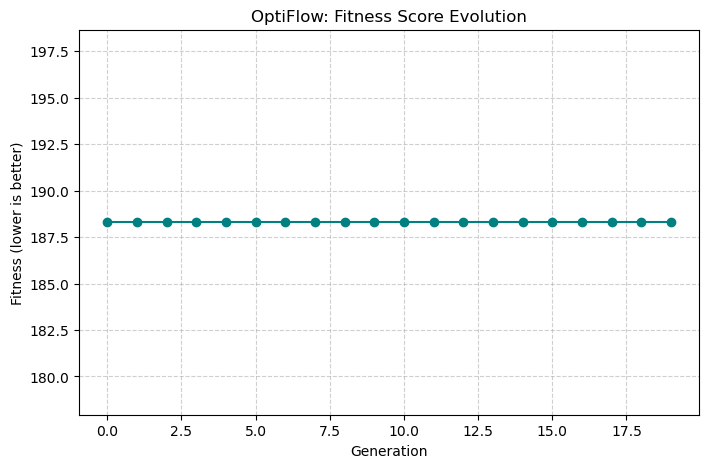

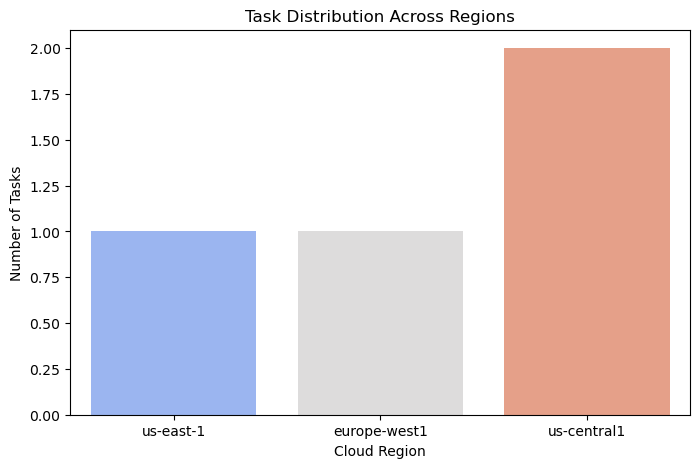

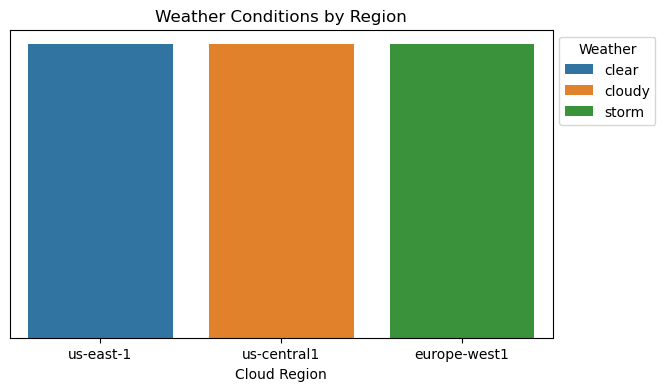


✅ Visualization complete.


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unpack the optimizer results (ensure you capture fitness_history)
best_assignment, best_score, fitness_history = genetic_optimizer(
    tasks, resources, weather_map,
    generations=20,
    population_size=10
)

# --- 1️⃣ Plot Fitness Evolution ---
plt.figure(figsize=(8,5))
plt.plot(fitness_history, marker='o', color='teal')
plt.title("OptiFlow: Fitness Score Evolution")
plt.xlabel("Generation")
plt.ylabel("Fitness (lower is better)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 2️⃣ Plot Task Assignments ---
assignment_data = [(tid, resources[rid]['region']) for tid, rid in best_assignment.items()]
df_assign = pd.DataFrame(assignment_data, columns=['Task ID', 'Region'])

plt.figure(figsize=(8,5))
sns.countplot(data=df_assign, x='Region', palette='coolwarm')
plt.title("Task Distribution Across Regions")
plt.xlabel("Cloud Region")
plt.ylabel("Number of Tasks")
plt.show()

# --- 3️⃣ Weather Visualization ---
weather_df_plot = pd.DataFrame(list(weather_map.items()), columns=['Region', 'Condition'])
plt.figure(figsize=(7,4))
sns.barplot(data=weather_df_plot, x='Region', y=[1]*len(weather_df_plot), hue='Condition', dodge=False)
plt.title("Weather Conditions by Region")
plt.yticks([])
plt.xlabel("Cloud Region")
plt.legend(title='Weather', bbox_to_anchor=(1,1))
plt.show()

print("\n✅ Visualization complete.")


#### Optional

In [1]:
import requests

def get_live_weather(region):
    api_key = "YOUR_API_KEY"
    response = requests.get(f"https://api.openweathermap.org/data/2.5/weather?q={region}&appid={api_key}")
    data = response.json()
    return data["weather"][0]["main"]
